In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
CFG = {
    'sigmoid': True,
    'bias': True,
    'init': True,
    'lr': 0.005,
    'num_epochs': 10,
}

In [3]:
DATA_DIR = './data/ml-latest-small/'
dfm = pd.read_csv(DATA_DIR+'movies.csv')
df = pd.read_csv(DATA_DIR+'ratings.csv')
df = df.merge(dfm, on='movieId', how='left')
df = df.sort_values(['userId', 'timestamp'], ascending=[True, True])
df = df.reset_index(drop=True)
df.head(3)

,userId,movieId,rating,timestamp,title,genres
0,1,804,4.0,964980499,She's the One (1996),Comedy|Romance
1,1,1210,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,1,2018,5.0,964980523,Bambi (1942),Animation|Children|Drama


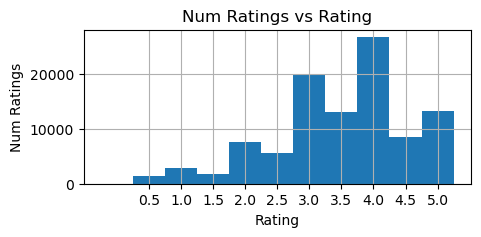

In [4]:
plt.figure(figsize=(5,2))
bins = np.arange(0,6,0.5)-0.25
plt.hist(df.rating.values, bins=bins)
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.title('Num Ratings vs Rating')
plt.xlabel('Rating')
plt.ylabel('Num Ratings')
plt.grid();

In [5]:
# Use LabelEncoder to convert users and movies into categorical
# This step remaps each column integer range to [0, len(df.column.unique())-1]
# Remapping is useful to reduce memory size of nn.embeddings
d = defaultdict(LabelEncoder)
cols_cat = ['userId', 'movieId']
for c in cols_cat:
    d[c].fit(df[c].unique())
    df[c] = d[c].transform(df[c])
    print(f'# unique {c}: {len(d[c].classes_)}')

min_num_ratings = df.groupby(['userId'])['userId'].transform(len).min()
print(f'Min # of ratings per user: {min_num_ratings}')
print(f'Min/Max rating: {df.rating.min()}/{df.rating.max()}')
print(f'df.shape: {df.shape}')
df.head(3)

# unique userId: 610
# unique movieId: 9724
Min # of ratings per user: 20
Min/Max rating: 0.5/5.0
df.shape: (100836, 6)


,userId,movieId,rating,timestamp,title,genres
0,0,632,4.0,964980499,She's the One (1996),Comedy|Romance
1,0,910,5.0,964980499,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,0,1492,5.0,964980523,Bambi (1942),Animation|Children|Drama


In [6]:
# Make train and val dataset
# 610 unique users. Each user has minimum 20 rated movies
# For val dataset, use last 5 rated movies per user
df_train = df.groupby('userId').head(-5).reset_index(drop=True)
df_val = df.groupby('userId').tail(5).reset_index(drop=True)
print(df_train.shape, df_val.shape)

(97786, 6) (3050, 6)


In [7]:
class MovieDataset(Dataset):
    def __init__(self, df):
        self.df = df[['userId', 'movieId', 'rating']]
        self.x_user_movie = list(zip(df.userId.values, df.movieId.values))
        self.y_rating = self.df.rating.values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.x_user_movie[idx], self.y_rating[idx]

In [8]:
BS = 8192
ds_train = MovieDataset(df_train)
ds_val = MovieDataset(df_val)
dl_train = DataLoader(ds_train, BS, shuffle=True, num_workers=4)
dl_val = DataLoader(ds_val, BS, shuffle=True, num_workers=4)

xb, yb = next(iter(dl_train))
print(xb)
print(yb)

[tensor([129, 259, 599,  ..., 300,  97, 293]), tensor([ 512,   98, 1443,  ...,  334, 6968,  263])]
tensor([2.0000, 5.0000, 5.0000,  ..., 2.5000, 4.0000, 3.0000],
       dtype=torch.float64)


In [9]:
def sigmoid_range(x, low, high):
    """ Sigmoid function with range (low, high) """
    return torch.sigmoid(x) * (high-low) + low

class MFAdvanced(nn.Module):
    """ Matrix factorization + user & item bias, weight init., sigmoid_range """
    def __init__(self, num_users, num_items, emb_dim, init, bias, sigmoid):
        super().__init__()
        self.bias = bias
        self.sigmoid = sigmoid
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        if bias:
            self.user_bias = nn.Parameter(torch.zeros(num_users))
            self.item_bias = nn.Parameter(torch.zeros(num_items))
            self.offset = nn.Parameter(torch.zeros(1))
        if init:
            self.user_emb.weight.data.uniform_(0., 0.05)
            self.item_emb.weight.data.uniform_(0., 0.05)
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        element_product = (user_emb*item_emb).sum(1)
        if self.bias:
            user_b = self.user_bias[user]
            item_b = self.item_bias[item]
            element_product += user_b + item_b + self.offset
        if self.sigmoid:
            return sigmoid_range(element_product, 0, 5.5)
        return element_product

In [10]:
def round_to_0p5(list_nums):
    """ Helper func to round nums to nearest 0.5, eg 1.45 -> 1.5 """
    return np.round(np.array(list_nums)*2)/2

In [ ]:
n_users = len(df.userId.unique())
n_items = len(df.movieId.unique())
mdl = MFAdvanced(n_users, n_items, emb_dim=32,
                 init=CFG['init'],
                 bias=CFG['bias'],
                 sigmoid=CFG['sigmoid'],
)
mdl.to(device)
print(dict(mdl.named_parameters()).keys())

In [ ]:
opt = optim.Adam(mdl.parameters(), lr=CFG['lr'])
loss_fn = nn.MSELoss()
epoch_train_losses, epoch_val_losses = [], []

for i in range(CFG['num_epochs']):
    train_losses, val_losses = [], []
    mdl.train()
    for xb,yb in dl_train:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    lpreds, lratings = [], []
    mdl.eval()
    for xb,yb in dl_val:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        val_losses.append(loss.item())
        # Start F1, precision, recall calculation
        lpreds.extend(preds.detach().cpu().numpy().tolist())
        lratings.extend(yRatings.detach().cpu().numpy().tolist())
    # Start logging
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    # For f1, precision, recall -> round preds to 0.5 and multiply by 2.
    # This turns fractional values to integers. Eg 1.34 -> 1.5 -> 3
    y_true = round_to_0p5(lpreds)*2
    y_hat = np.array(lratings)*2
    f1 = f1_score(y_true, y_hat, average='macro', zero_division=0)
    precision = precision_score(y_true, y_hat, average='macro', zero_division=0)
    recall = recall_score(y_true, y_hat, average='macro', zero_division=0)
    s = (f'Epoch: {i}, Train Loss: {epoch_train_loss:0.1f}, '
         f'Val Loss: {epoch_val_loss:0.1f}, F1: {f1:0.2f}, '
         f'prec.: {precision:0.2f}, rec: {recall:0.2f}')
    print(s)

In [ ]:
plt.figure(figsize=(5,2))
plt.plot(epoch_train_losses, label='Train')
plt.plot(epoch_val_losses, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend();

In [ ]:
user_emb_min_w = mdl.user_emb.weight.min().item()
user_emb_max_w = mdl.user_emb.weight.max().item()
item_emb_min_w = mdl.item_emb.weight.min().item()
item_emb_max_w = mdl.item_emb.weight.max().item()
print(f'Emb user min/max w: {user_emb_min_w:0.3f} / {user_emb_max_w:0.3f}')
print(f'Emb item min/max w: {item_emb_min_w:0.3f} / {item_emb_max_w:0.3f}')
print(f'Preds min/max: {preds.min().item():0.2f} / {preds.max().item():0.2f}')
y_rate_min, y_rate_max = yRatings.min().item(), yRatings.max().item()
print(f'Rating min/max: {y_rate_min:0.2f} / {y_rate_max:0.2f}')
print(preds.detach().cpu().numpy()[:6])
print(yRatings.detach().cpu().numpy()[:6])